In [1]:
from QuantLib import *
today = Date(2, May, 2016)
Settings.instance().evaluationDate = today


In [2]:
%%capture
%pylab inline --no-import-all
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt

def plot_curves(*curves):
    fig, ax = plt.subplots()
    ax.yaxis.set_major_formatter(FuncFormatter(lambda r,pos: r))
    ax.set_xlim(0,15)
    ax.set_xticks([0,5,10,15])
    times = numpy.linspace(0.0, 15.0, 400)
    for curve, style in curves:
        rates = [ curve.zeroRate(t, Continuous).rate() for t in times ]
        plt.plot(times, rates, style)
        
def plot_curve(curve):
    plot_curves((curve,'-'))

In [3]:
quotes = [ SimpleQuote(0.312/100) ]
helpers = [ DepositRateHelper(QuoteHandle(quotes[0]),
                              Period(6,Months), 3,
                              TARGET(), Following, False, Actual360()) ]
for rate, months_to_start in [(0.293, 1), (0.272, 2), (0.260, 3),
                              (0.256, 4), (0.252, 5), (0.248, 6),
                              (0.254, 7), (0.261, 8), (0.267, 9),
                              (0.279, 10), (0.291, 11), (0.303, 12),
                              (0.318, 13), (0.335, 14), (0.352, 15),
                              (0.371, 16), (0.389, 17), (0.409, 18)]:
    quotes.append(SimpleQuote(rate/100))
    helpers.append(FraRateHelper(QuoteHandle(quotes[-1]), months_to_start, Euribor6M()))
    
for rate, tenor in [(0.424, 3), (0.576, 4), (0.762, 5), (0.954, 6),
                    (1.135, 7), (1.303, 8), (1.452, 9), (1.584, 10),
                    (1.809, 12), (2.037, 15), (2.187, 20), (2.234, 25),
                    (2.256, 30), (2.295, 35), (2.348, 40), (2.421, 50),
                    (2.463, 60)]:
    quotes.append(SimpleQuote(rate/100))
    helpers.append(SwapRateHelper(QuoteHandle(quotes[-1]), 
                                  Period(tenor, Years), TARGET(),
                                  Annual, Unadjusted, Thirty360(Thirty360.BondBasis),
                                  Euribor6M()))
    
rate_curve = PiecewiseLogCubicDiscount(2, TARGET(), helpers, Actual365Fixed())
curve_handle = RelinkableYieldTermStructureHandle(rate_curve)


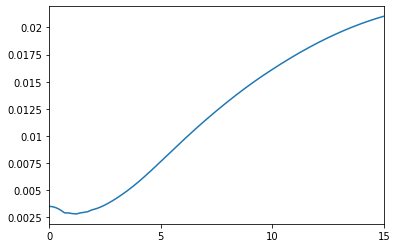

In [4]:
plot_curve(rate_curve)

In [5]:
fixed_schedule = Schedule(Date(9, May, 2022), Date(9, May, 2032),
                          Period(1, Years), TARGET(), Following, Following,
                          DateGeneration.Forward, False)
floating_schedule = Schedule(Date(9, May, 2022), Date(9, May, 2032),
                             Period(6, Months), TARGET(), Following, Following,
                             DateGeneration.Forward, False)
index = Euribor6M(curve_handle)
swap = VanillaSwap(VanillaSwap.Payer, 10000.0,
                   fixed_schedule, 0.02, Thirty360(),
                   floating_schedule, index, 0.0, Actual360())
swap.setPricingEngine(DiscountingSwapEngine(curve_handle))

In [9]:
npv = swap.NPV()
fair_spd = swap.fairSpread()
fair_rate = swap.fairRate()
fix_bps = swap.fixedLegBPS()
float_bps = swap.floatingLegBPS()
print(npv, fair_spd, fair_rate, fix_bps, float_bps)

731.7068190529744 -0.008795847662862387 0.028989919487710618 -8.139192125727387 8.318775484736612


In [7]:
for i, cf in enumerate(swap.leg(0)):
    print("%2d    %-18s %10.2f" % (i+1, cf.date(), cf.amount()))


 1    May 9th, 2023          200.00
 2    May 9th, 2024          200.00
 3    May 9th, 2025          200.00
 4    May 11th, 2026         201.11
 5    May 10th, 2027         199.44
 6    May 9th, 2028          199.44
 7    May 9th, 2029          200.00
 8    May 9th, 2030          200.00
 9    May 9th, 2031          200.00
10    May 10th, 2032         200.56


In [8]:
for i, cf in enumerate(swap.leg(1)):
    print("%2d    %-18s %10.2f" % (i+1, cf.date(), cf.amount()))

 1    November 9th, 2022     111.15
 2    May 9th, 2023          116.41
 3    November 9th, 2023     124.79
 4    May 9th, 2024          129.42
 5    November 11th, 2024     137.93
 6    May 9th, 2025          137.07
 7    November 10th, 2025     145.26
 8    May 11th, 2026         146.46
 9    November 9th, 2026     150.07
10    May 10th, 2027         153.08
11    November 9th, 2027     156.22
12    May 9th, 2028          156.90
13    November 9th, 2028     159.45
14    May 9th, 2029          156.95
15    November 9th, 2029     159.00
16    May 9th, 2030          155.15
17    November 11th, 2030     157.48
18    May 9th, 2031          148.95
19    November 10th, 2031     150.82
20    May 10th, 2032         145.30


In [10]:
bp = 1.0e-4
ref = quotes[0].value()
quotes[0].setValue(ref+1*bp)
print(swap.NPV())
quotes[0].setValue(ref)

-190.1069970119836


In [11]:
for q in quotes:
    q.setValue(q.value()+1*bp)
print(swap.NPV())
for q in quotes:
    q.setValue(q.value()-1*bp)

-178.68820577843803


In [12]:
base_curve = YieldTermStructureHandle(rate_curve)
spread = SimpleQuote(1*bp)
curve_handle.linkTo(ZeroSpreadedTermStructure(base_curve, QuoteHandle(spread)))
print(swap.NPV())

-178.8676404436858


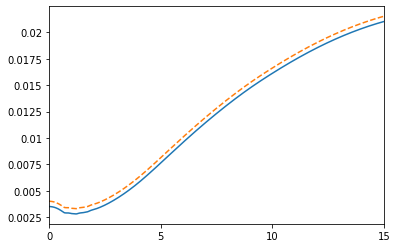

In [13]:
spread.setValue(5*bp)
plot_curves((rate_curve,'-'), (curve_handle,'--'))

-138.69485276964406


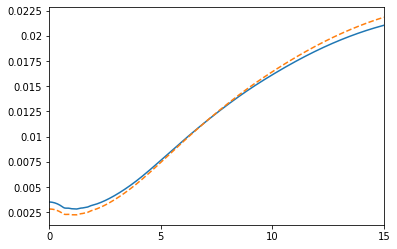

In [14]:
spot = rate_curve.referenceDate()
dates = [ spot + Period(n,Years) for n in range(21)]
spreads = [ QuoteHandle(SimpleQuote((n-7)*bp)) for n in range(21) ]
curve_handle.linkTo(SpreadedLinearZeroInterpolatedTermStructure(base_curve, spreads, dates))
plot_curves((rate_curve,'-'), (curve_handle,'--'))
print(swap.NPV())

In [15]:
curve_handle.linkTo(rate_curve)
print(swap.NPV())

-189.83267949204537
